In [101]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv("data/divorce_data.csv", sep=";")
df = pd.concat([df.iloc[:, 0:20], df.iloc[:, -1]], axis=1) 

X = df.drop("Divorce", axis=1).to_numpy()
y = df["Divorce"].to_numpy()

X = StandardScaler().fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

y_train_tensor.shape

torch.Size([136])

In [98]:
NUM_EPOCHS = 1000
LEARNING_RATE = 0.001
HIDDEN_SIZE = 100
HIDDEN_COUNT = 2
NUM_CLASSES = len(label_encoder.classes_)

In [103]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_count, num_classes):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_count = hidden_count
        self.num_classes = num_classes

        self.stack = nn.Sequential()
        self.stack.add_module("fcfirst", nn.Linear(input_size, hidden_size))
        self.stack.add_module(f"relufirst", nn.ReLU())


        for i in range(hidden_count):
            self.stack.add_module(f"fc{i}", nn.Linear(hidden_size, hidden_size))
            self.stack.add_module(f"relu{i}", nn.ReLU())

        self.stack.add_module("fclast", nn.Linear(hidden_size, num_classes))  
        self.stack.add_module("last", nn.Softmax(dim=1))
    
    def forward(self, x):
        out = self.stack(x)
        return out
    
    def shape(self):
        return self.input_size, self.hidden_size, self.hidden_count, self.num_classes
    
    def save(self, file_name="model.pth"):
        model_folder_path = "./models"
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

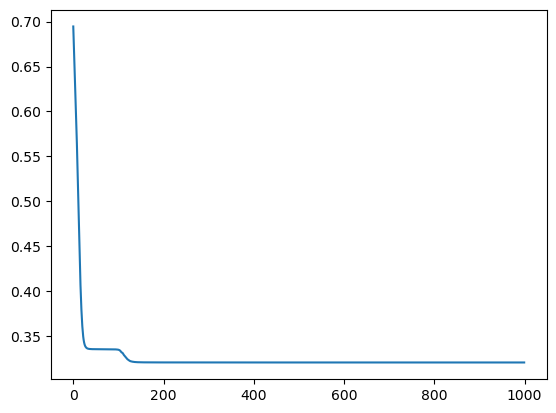

In [104]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
net = Net(X.shape[1], HIDDEN_SIZE, HIDDEN_COUNT, NUM_CLASSES)
optimizer = optim.Adam(net.parameters(), LEARNING_RATE)

losses = []
for epoch in range(NUM_EPOCHS):
    net.train()
    net.zero_grad()
    y_pred = net(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

clear_output(wait=True)
plt.plot(losses)
plt.show()

In [105]:
net.eval()
with torch.no_grad():
    outputs = net(X_test_tensor)
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 97.06%


In [106]:
net.save()